In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
# Download the dataset if you haven't already
import requests
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
response = requests.get(url)
with open("course_lead_scoring.csv", "wb") as f:
    f.write(response.content)
# Load the dataset
df = pd.read_csv('course_lead_scoring.csv')
# Handle missing values
# For categorical features, replace with 'NA'
# For numerical features, replace with 0.0
# First, identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns
# Replace missing values
for col in categorical_columns:
    df[col] = df[col].fillna('NA')
for col in numerical_columns:
    df[col] = df[col].fillna(0.0)
# Split the data into train, validation, and test sets (60%/20%/20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2
print(f"Train set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")
# Separate features and target
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values
# Remove target from features
del df_train['converted']
del df_val['converted']
del df_test['converted']

Train set size: 876
Validation set size: 293
Test set size: 293


In [3]:
from sklearn.metrics import roc_auc_score
# Numerical variables to check
numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
# Calculate AUC for each numerical variable
auc_scores = {}
for var in numerical_vars:
    # Use the variable as the prediction score
    score = df_train[var].values
    
    # Calculate AUC
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        print(f"{var}: AUC = {auc:.3f} (inverted)")
    else:
        print(f"{var}: AUC = {auc:.3f}")
    
    auc_scores[var] = auc

# Find the variable with the highest AUC
highest_auc_var = max(auc_scores, key=auc_scores.get)
print(f"\nVariable with highest AUC: {highest_auc_var} with AUC = {auc_scores[highest_auc_var]:.3f}")

lead_score: AUC = 0.614
number_of_courses_viewed: AUC = 0.764
interaction_count: AUC = 0.738
annual_income: AUC = 0.552

Variable with highest AUC: number_of_courses_viewed with AUC = 0.764


In [4]:
from sklearn.feature_extraction import DictVectorizer
# Convert dataframes to list of dictionaries
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
# Calculate predictions (probabilities) on validation set
y_val_pred = model.predict_proba(X_val)[:, 1]
# Calculate AUC on validation set
val_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {val_auc:.3f}")

Validation AUC: 0.817


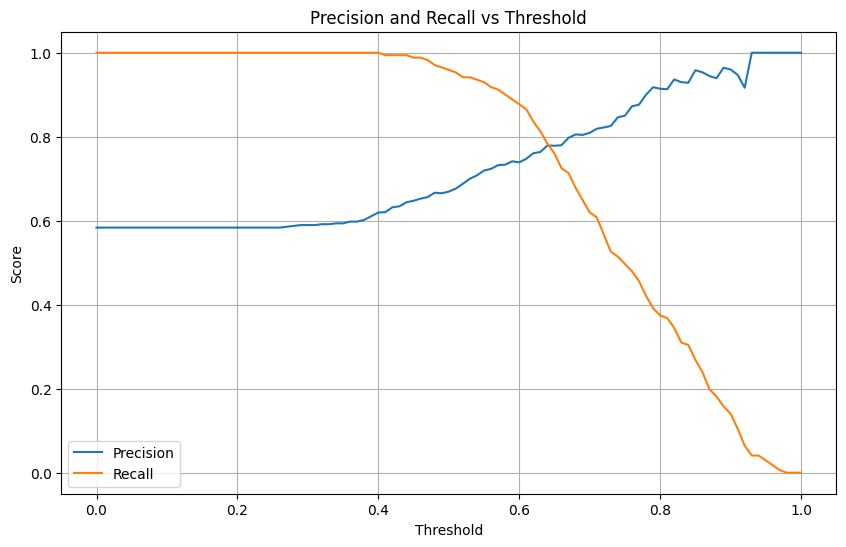

Precision and recall intersect at threshold = 0.640 with value ≈ 0.781


In [5]:
from sklearn.metrics import precision_score, recall_score
# Evaluate model on different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_val_binary = (y_val_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_val_binary, zero_division=1)  # Use zero_division=1 to handle cases with no positive predictions
    recall = recall_score(y_val, y_val_binary)
    
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
# Find where precision and recall curves intersect
intersection_idx = np.argmin(np.abs(np.array(precision_scores) - np.array(recall_scores)))
intersection_threshold = thresholds[intersection_idx]
intersection_value = (precision_scores[intersection_idx] + recall_scores[intersection_idx]) / 2
print(f"Precision and recall intersect at threshold = {intersection_threshold:.3f} with value ≈ {intersection_value:.3f}")

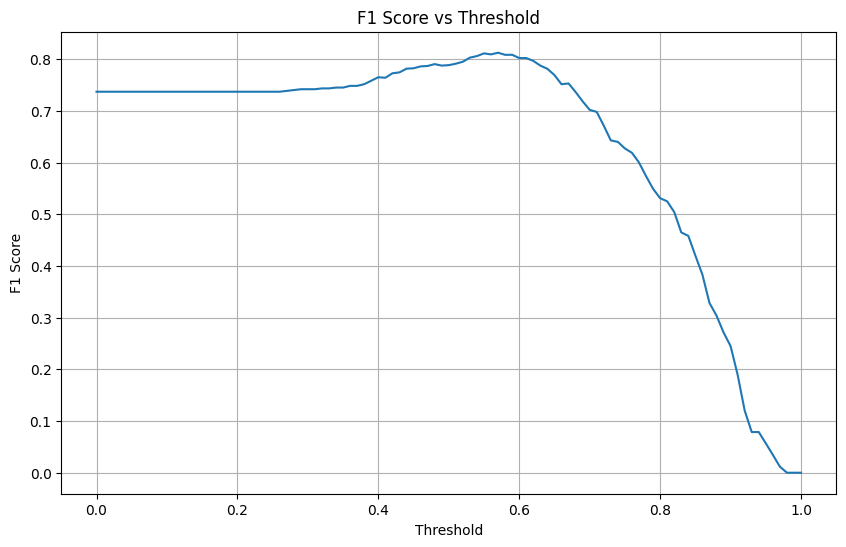

Maximum F1 score of 0.812 is achieved at threshold = 0.57


In [6]:
# Calculate F1 score for each threshold
f1_scores = []
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_val_binary = (y_val_pred >= threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_val_binary)
    f1_scores.append(f1)

# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()
# Find threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1 = f1_scores[max_f1_idx]
print(f"Maximum F1 score of {max_f1:.3f} is achieved at threshold = {max_f1_threshold:.2f}")

In [7]:
from sklearn.model_selection import KFold
# Prepare full training dataset (train + validation)
df_full_train_dicts = df_full_train.drop('converted', axis=1).to_dict(orient='records')
y_full_train = df_full_train['converted'].values
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
# Store AUC scores for each fold
fold_auc_scores = []
# Iterate over folds
for train_idx, val_idx in kf.split(df_full_train_dicts):
    # Split data into train and validation for this fold
    train_dicts = [df_full_train_dicts[i] for i in train_idx]
    val_dicts = [df_full_train_dicts[i] for i in val_idx]
    
    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]
    
    # Vectorize the data
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dicts)
    X_val_fold = dv.transform(val_dicts)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_val_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_val_fold, y_val_pred_fold)
    fold_auc_scores.append(auc)
    
    print(f"Fold AUC: {auc:.3f}")

# Calculate mean and standard deviation of AUC scores
mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

print(f"Mean AUC: {mean_auc:.3f}")
print(f"Standard deviation of AUC: {std_auc:.3f}")

Fold AUC: 0.806
Fold AUC: 0.871
Fold AUC: 0.775
Fold AUC: 0.802
Fold AUC: 0.856
Mean AUC: 0.822
Standard deviation of AUC: 0.036


In [8]:
# C values to try
c_values = [0.000001, 0.001, 1]
# Store results for each C
c_results = {}
for c in c_values:
    print(f"\nEvaluating C = {c}")
    
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Store AUC scores for each fold
    fold_auc_scores = []
    
    # Iterate over folds
    for train_idx, val_idx in kf.split(df_full_train_dicts):
        # Split data into train and validation for this fold
        train_dicts = [df_full_train_dicts[i] for i in train_idx]
        val_dicts = [df_full_train_dicts[i] for i in val_idx]
        
        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]
        
        # Vectorize the data
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dicts)
        X_val_fold = dv.transform(val_dicts)
        
        # Train the model with current C value
        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_val_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_val_fold, y_val_pred_fold)
        fold_auc_scores.append(auc)
    
    # Calculate mean and standard deviation of AUC scores for this C
    mean_auc = round(np.mean(fold_auc_scores), 3)
    std_auc = round(np.std(fold_auc_scores), 3)
    
    c_results[c] = {
        'mean_auc': mean_auc,
        'std_auc': std_auc
    }
    
    print(f"C = {c}: Mean AUC = {mean_auc}, Std = {std_auc}")

# Find the C with the best mean AUC
best_c_values = []
best_mean_auc = max(result['mean_auc'] for result in c_results.values())

for c, result in c_results.items():
    if result['mean_auc'] == best_mean_auc:
        best_c_values.append((c, result['std_auc']))

# If there are ties, select the one with the lowest std
if len(best_c_values) > 1:
    best_c = min(best_c_values, key=lambda x: (x[1], x[0]))[0]
else:
    best_c = best_c_values[0][0]

print(f"\nBest C value: {best_c} with mean AUC = {c_results[best_c]['mean_auc']} and std = {c_results[best_c]['std_auc']}")


Evaluating C = 1e-06
C = 1e-06: Mean AUC = 0.56, Std = 0.024

Evaluating C = 0.001
C = 0.001: Mean AUC = 0.867, Std = 0.029

Evaluating C = 1
C = 1: Mean AUC = 0.822, Std = 0.036

Best C value: 0.001 with mean AUC = 0.867 and std = 0.029
